In [1]:
import numpy as np
from astropy.io import fits
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os


In [2]:
os.getcwd()

'/home/dices/Research/GWlensing_Brian'

In [5]:

Name = "Abell 370"
name = "abell370"
data_path = f"/home/dices/Research/GWlensing_Brian/GCdata/{Name}/diego/range/"  # change this to the actual path where your FITS files are located
#Build the file pattern
x_file_pattern = os.path.join(data_path, f"hlsp_frontier_model_{name}_diego-map???_v4.1_x-arcsec-deflect.fits")
y_file_pattern = os.path.join(data_path, f"hlsp_frontier_model_{name}_diego-map???_v4.1_y-arcsec-deflect.fits")
file_list_x = sorted(glob.glob(x_file_pattern))
file_list_y = sorted(glob.glob(y_file_pattern))
N_files_x = len(file_list_x)
N_files_y = len(file_list_y)
print(f"Found {N_files_x} x FITS files and {N_files_y} y FITS files.")

file_list = file_list_x
N_files = len(file_list)

# Read the first FITS to get dimensions
first_map = fits.getdata(file_list[0])
H, W = first_map.shape
print(f"Dimensions of the potential maps: {H} x {W}")
# Pre-allocate an array for the potentials: shape (N_files, H, W)
potentials = np.empty((N_files, H, W))

for i, filename in enumerate(file_list):
    data = fits.getdata(filename)
    if data.shape != (H, W):
        raise ValueError(f"File {filename} has shape {data.shape}, expected ({H}, {W})")
    potentials[i] = data


Found 100 x FITS files and 100 y FITS files.
Dimensions of the potential maps: 512 x 512


Upper bound relative uncertainty in |alpha|: 3.4363%


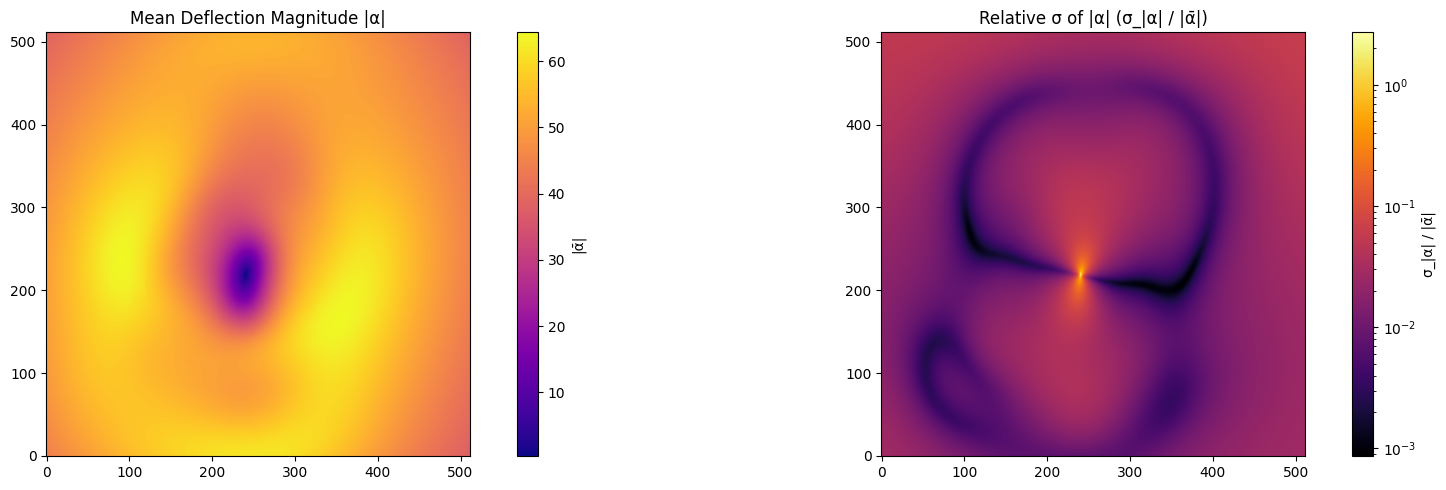

In [6]:
# pixel size (arcsec/pixel)
dx = 0.42
dy = 0.42

# Load α maps: shape (N_files, H, W, 2)
alpha_maps = np.empty((N_files, H, W, 2), dtype=np.float64)
for i in range(N_files):
    dx_map = fits.getdata(file_list_x[i]).astype(np.float64)
    dy_map = fits.getdata(file_list_y[i]).astype(np.float64)
    alpha_maps[i] = np.stack((dx_map, dy_map), axis=-1)

# Ensemble mean of components
alpha_mean = np.mean(alpha_maps, axis=0)                # (H, W, 2)
alpha_mean_mag = np.linalg.norm(alpha_mean, axis=-1)    # (H, W)

# Compute |α| per map, then take sample std across the ensemble.
alpha_mag = np.linalg.norm(alpha_maps, axis=-1)         # (N_files, H, W)
sigma_abs = np.std(alpha_mag, axis=0, ddof=1)           # (H, W)  == σ_|α|

# Relative uncertainty map (per pixel)
eps = 1e-12     #avoid zeros
relative_sigma = sigma_abs / np.maximum(alpha_mean_mag, eps)

# Overall upper bound (84th percentile σ)
upper_bound_fraction = np.percentile(relative_sigma, 84.0)
upper_bound_percentage = upper_bound_fraction * 100.0
print(f"Upper bound relative uncertainty in |alpha|: {upper_bound_percentage:.4f}%")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

im1 = axes[0].imshow(alpha_mean_mag, origin='lower', cmap='plasma')
axes[0].set_title("Mean Deflection Magnitude |α|")
plt.colorbar(im1, ax=axes[0], label="|ᾱ|")

im2 = axes[1].imshow(relative_sigma, origin='lower', cmap='inferno', norm=LogNorm())
axes[1].set_title("Relative σ of |α| (σ_|α| / |ᾱ|)")
plt.colorbar(im2, ax=axes[1], label="σ_|α| / |ᾱ|")

plt.tight_layout()
plt.show()

# # Extract x and y components of the mean and std
# alpha_mean_x = alpha_mean[:, :, 0]
# alpha_std_x  = alpha_std[:, :, 0]

# alpha_mean_y = alpha_mean[:, :, 1]
# alpha_std_y  = alpha_std[:, :, 1]

# # Avoid division by zero
# alpha_mean_x_safe = np.where(np.abs(alpha_mean_x) < 1e-10, 1e-10, alpha_mean_x)
# alpha_mean_y_safe = np.where(np.abs(alpha_mean_y) < 1e-10, 1e-10, alpha_mean_y)

# # Relative uncertainties (per pixel) for each component:
# rel_unc_x = alpha_std_x / np.abs(alpha_mean_x_safe)
# rel_unc_y = alpha_std_y / np.abs(alpha_mean_y_safe)

# # Upper bound uncertainty (84th percentile) for each component:
# upper_bound_rel_unc_x = np.percentile(rel_unc_x, 84) * 100  # as a percentage
# upper_bound_rel_unc_y = np.percentile(rel_unc_y, 84) * 100  # as a percentage

# print(f"Upper bound relative uncertainty in α_x: {upper_bound_rel_unc_x:.2f}%")
# print(f"Upper bound relative uncertainty in α_y: {upper_bound_rel_unc_y:.2f}%")

In [ ]:
# reconstruct the lens potential maps by deflection angle maps by integration